In [1]:
import lithosim_cuda as litho
import os, argparse
from fnmatch import fnmatch
import torch
from torchvision import transforms
from torch.utils.data import Dataset
# import matplotlib
# %matplotlib widget
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

parser = argparse.ArgumentParser(description='take parameters')
parser.add_argument('--kernels_root', type=str,
                    default='lithosim_kernels/bin_data')
parser.add_argument('--kernel_type', type=str,
                    default='focus', help='[focus] or [defocus]')
parser.add_argument('--input_root', type=str, default='../dataset/input/')
parser.add_argument('--output_root', type=str,
                    default='../output/litho_output')
parser.add_argument('--kernel_num', type=int, default=24, help='24 SOCS kernels')
parser.add_argument('--device_id', type=int, default=0, help='GPU device id')
parser.add_argument('--threshold', type=float, default=0.225, help='Resist threshold')
# args = parser.parse_args()
args = parser.parse_known_args()[0]

device = torch.device('cuda:' + str(args.device_id) if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [2]:
class PNGFolderDataset(Dataset):
    def __init__(self, root, transform=None, image_size=224):
        self.filenames = []
        for path, subdirs, files in os.walk(root):
            for name in files:
                if fnmatch(name, '*.png'):
                    self.filenames.append(os.path.join(path, name))
        self.filenames.sort()
        self.transform = transform or transforms.Compose([
            transforms.Resize((image_size, image_size)),
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = self.filenames[idx]
        img_tensor = litho.load_image(img_path)
        if self.transform is not None:
            img_tensor = self.transform(img_tensor)
        return img_tensor

In [3]:
def load_kernels_weights():
    kernels_root = args.kernels_root
    _, _, _ = litho.kernel_bin_preprocess(kernels_root, 'focus', verbose=False)
    _, _, _ = litho.kernel_bin_preprocess(kernels_root, 'defocus', verbose=False)

    litho_kernel_type = args.kernel_type
    torch_data_path = 'lithosim_kernels/torch_tensor'
    output_root = args.output_root

    if not os.path.exists(output_root):
        os.makedirs(output_root)

    kernels_path = os.path.join(
        torch_data_path, 'kernel_' + litho_kernel_type + '_tensor.pt')
    weight_path = os.path.join(
        torch_data_path, 'weight_' + litho_kernel_type + '_tensor.pt')

    kernels = torch.load(kernels_path, map_location=device)
    weight = torch.load(weight_path, map_location=device)
    return kernels, weight
    
def run_lithosim(image_data, kernels, weight, zernike_coeffs=None):
    r"""
    Run lithography simulation for a batch of masks (within the arg.input_root folder)
    """

    save_bin_wafer_image = False
    kernel_number = args.kernel_num
    threshold = args.threshold
    save_name = None
    
    intensity_map, binary_wafer = litho.lithosim(image_data, threshold, kernels, weight, save_name, save_bin_wafer_image,
                                     kernel_number, zernike_coeffs=zernike_coeffs)
    return intensity_map

kernels, weight = load_kernels_weights()

In [4]:
def litho_loss(pred, true, threshold, margin: float = 0.1):
    sign = torch.sign(true - threshold)
    return torch.clip((true-pred)*sign + margin, min=0.).mean() / torch.std(true)

def tensor_to_image(tensor):
    return tensor.detach().cpu().numpy().transpose(1,2,0)

### 1 image

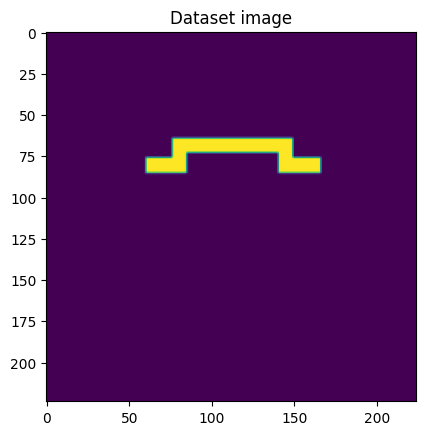

In [ ]:
dataset = PNGFolderDataset(args.input_root)

image = tensor_to_image(dataset.__getitem__(0))
plt.figure()
plt.imshow(image)
plt.title("Dataset image")
plt.show()

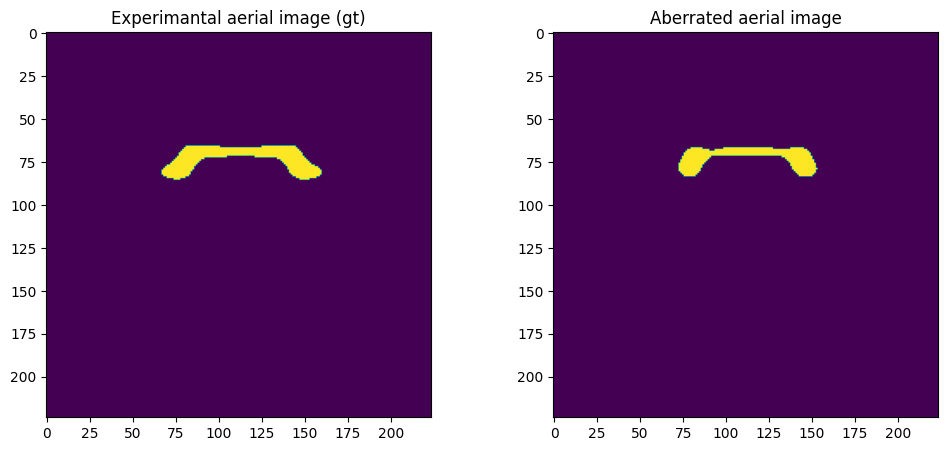

In [31]:
image = dataset.__getitem__(0).to(device)

plt.figure(figsize=(12,5))
ax=plt.subplot(1,2,1)
zernike_coeffs = torch.zeros((6,))
wafer_gt = run_lithosim(image, kernels, weight, zernike_coeffs)
plt.imshow(tensor_to_image(litho.mask_threshold(wafer_gt, args.threshold)))
ax.set_title("Experimantal aerial image (gt)")

ax=plt.subplot(1,2,2)
zernike_coeffs = torch.tensor([0, 0, 0, 5., 0, 0])
wafer = run_lithosim(image, kernels, weight, zernike_coeffs)
plt.imshow(tensor_to_image(litho.mask_threshold(wafer, args.threshold)))
ax.set_title("Aberrated aerial image")
plt.show()

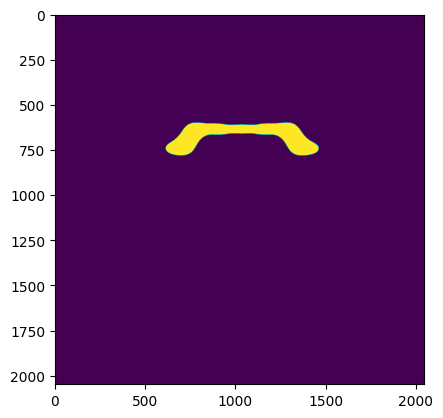

In [17]:
# zernike_coeffs = torch.tensor([0, 0, 0, 4., -4., 100], device=device, requires_grad=True)
zernike_coeffs = torch.tensor([0, 0, 0, 1., 0, 0], device=device, requires_grad=True)
wafer = run_lithosim(image, kernels, weight, zernike_coeffs)
plt.imshow(tensor_to_image(litho.mask_threshold(wafer, args.threshold)))
plt.show()

In [18]:
optimizer = torch.optim.AdamW([zernike_coeffs], lr=1e-1)
tq = tqdm(range(1000))
for it in tq:
    optimizer.zero_grad()
    wafer = run_lithosim(image, kernels, weight, zernike_coeffs)
    loss = litho_loss(wafer, wafer_gt, args.threshold, margin=1e-2)
    loss.backward()
    optimizer.step()
    tq.set_postfix_str(f"loss={loss.item()}")

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

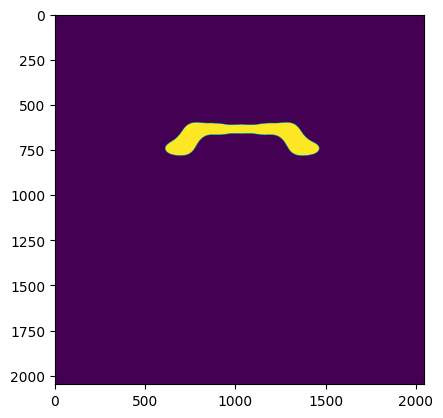

In [ ]:
plt.imshow(tensor_to_image(litho.mask_threshold(wafer, args.threshold)))
plt.show()

In [ ]:
litho_loss(wafer, wafer_gt, args.threshold)

tensor(25.6007, device='cuda:0', grad_fn=<MulBackward0>)

### Batch

In [5]:
data_path = os.path.join('..', 'dataset', 'train_layouts')
dataset = PNGFolderDataset(data_path)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=8)
batch = next(iter(dataloader))
batch.shape

torch.Size([64, 1, 224, 224])

In [ ]:
kernels, weight = load_kernels_weights()
zernike_coeffs = torch.tensor([0, 0, 0, 1., 0, 0], device=device, requires_grad=True)

optimizer = torch.optim.AdamW([zernike_coeffs], lr=1e-2)

with torch.autocast(device_type=device.type):
    for epoch in range(10):
        tq = tqdm(dataloader, total=len(dataloader))
        for batch in tq:
            batch = batch.to(device)
            optimizer.zero_grad()
            wafer = run_lithosim(batch, kernels, weight, zernike_coeffs)
            with torch.no_grad():
                wafer_gt = run_lithosim(batch, kernels, weight)
            loss = litho_loss(wafer, wafer_gt, args.threshold, margin=1e-2)
            loss.backward()
            optimizer.step()
            tq.set_postfix_str(f"loss={loss.item()}")

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2cbc107ec0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2cbc107ec0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2cbc107ec0>


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/root/anaconda3/envs/SK/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/root/anaconda3/envs/SK/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/root/anaconda3/envs/SK/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in: Exception ignored in:             <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2cbc107ec0>self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2cbc107ec0>
self._shutdown_workers()self._shutdown_w